In [1]:
#importing required libraries and packages
 
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
#printing out versions of all packages and libraries and used

print(f'pandas version is: {pd.__version__}')
print(f'numpy version is: {np.__version__}')
print(f'matplotlib version is: {matplotlib.__version__}')
print(f'sklearn version is: {sklearn.__version__}')
print(f'xgboost version is: {xgb.__version__}')
print(f'lightgbm version is: {lightgbm.__version__}')
print(f'catboost version is: {catboost.__version__}')

pandas version is: 1.2.4
numpy version is: 1.20.1
matplotlib version is: 3.3.4
sklearn version is: 0.24.1
xgboost version is: 1.3.3
lightgbm version is: 3.2.1
catboost version is: 1.0.0


In [3]:
#all helper functions used

def drop_columns(data, *args):

    '''
    function used to drop columns.
    args:: 
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''
    
    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.drop(columns, axis=1)
        
    return data
 
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data
 
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !pwd

In [6]:
#should be edited to the present working directory of the user
PWD = './'

In [7]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(PWD + 'penalty_matrix.npy')

train = pd.read_csv(PWD + 'train.csv')

test = pd.read_csv(PWD + 'test.csv')

In [8]:
test

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN,65000
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN,65000
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN,65000
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN,65000
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN,65000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,35/9-8,3224.389600,536225.93750,6794880.5,-3199.876465,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.231942,...,8.5,26.615782,118.669212,NaN,0.063478,NaN,2.618309,33.523922,NaN,30000
136782,35/9-8,3224.541600,536225.93750,6794880.5,-3200.028320,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.038777,...,8.5,25.647141,118.468925,NaN,0.056791,NaN,2.620221,32.643795,NaN,30000
136783,35/9-8,3224.693600,536225.93750,6794880.5,-3200.180176,BAAT GP.,Rannoch Fm.,8.4978,NaN,5.503983,...,8.5,23.929407,118.163177,NaN,0.002499,NaN,2.629171,31.763380,NaN,30000
136784,35/9-8,3224.845600,536225.93750,6794880.5,-3200.332031,BAAT GP.,Rannoch Fm.,8.4978,NaN,4.895551,...,8.5,22.737293,117.655937,NaN,0.003363,NaN,2.521121,30.884350,NaN,30000


In [9]:
class Model():

    '''
    class to lithology prediction
    '''
    
    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''
        
        self.train = train
        self.test = test

        
    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''

        

        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')
 
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        
        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')
    
        return traindata1, testdata1, lithology1, lithology_numbers

    
    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)
      # self.train_processed = traindata1
      # self.test_processed = testdata1
      # self.test_labels = 

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      open_test = np.zeros((len(testdata1), 12))
      
      #100 n-estimators and 10 max-depth
#       model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
#                             objective='multi:softprob', learning_rate=0.1, random_state=0,
#                             subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
#                             eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
    
#       model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=10, learning_rate=0.1,
#                             n_estimators=100, subsample_for_bin=200000, colsample_bytree=1.0, 
#                              random_state=0, reg_alpha=0.0, reg_lambda=0.0)

      model = CatBoostClassifier(learning_rate=0.1, depth=10, random_seed=0, reg_lambda=0.0,
                                n_estimators=100)
      
 
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

                  
      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)
 
      path = PWD
    
      test = pd.read_csv(PWD + 'test.csv')
      
      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))
0:	learn: 1.8776492	test: 1.8788419	best: 1.8788419 (0)	total: 14.6s	remaining: 24m 3s
99:	learn: 0.2928078	test: 0.3028816	best: 0.3028816 (99)	total: 16m 59s	remaining: 0us

bestTest = 0.3028816054
bestIteration = 99

Default score: [-0.27016625]
Accuracy is: 0.8963879301507023
F1 is: 0.8996918440107387
None
-----------------------FOLD 1---------------------
0:	learn: 1.8779512	test: 1.8774943	best: 1.8774943 (0)	total: 13.3s	remaining: 21m 55s
99:	learn: 0.2913720	test: 0.30089

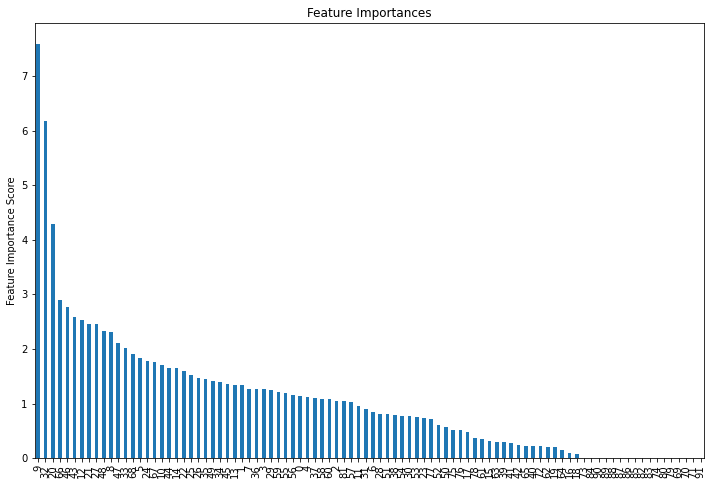

In [10]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [11]:
prediction

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [12]:
wells_df = pd.read_csv('test.csv')
wells_df.head()
well_names = wells_df['WELL'].unique()
# map of lithology codes to description
lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}
    
# map of lithology codes to integer label for ML
lithology_numbers = {30000: 0,
             65030: 1,
             65000: 2,
             80000: 3,
             74000: 4,
             70000: 5,
             70032: 6,
             88000: 7,
             86000: 8,
             99000: 9,
             90000: 10,
             93000: 11}
    
def map_lith_key(lith_map, row):
    
    lith_key = row['FORCE_2020_LITHOFACIES_LITHOLOGY']
    
    if lith_key in lith_map:
        return lith_map[lith_key]
    else:
        print('Warning: Key {} not found in map'.format(lith_key))
        return np.nan

wells_df['LITHOLOGY'] = wells_df.apply (lambda row: map_lith_key(lithology_keys, row), axis=1)
wells_df['LITH_LABEL'] = wells_df.apply (lambda row: map_lith_key(lithology_numbers, row), axis=1)

In [13]:
wells_df['PRED_LABEL'] = prediction

In [14]:
print('----------------TEST EVALUATION------------------')
print(f"Accuracy Score: {accuracy_score(wells_df['LITH_LABEL'], wells_df['PRED_LABEL'])}")
print(f"F1 Score: {f1_score(wells_df['LITH_LABEL'], wells_df['PRED_LABEL'], average='weighted')}")

----------------TEST EVALUATION------------------
Accuracy Score: 0.7838960127498428
F1 Score: 0.7565474186411658


In [15]:
facies_color_map = { 'Sandstone': '#F4D03F',
                     'Sandstone/Shale': '#7ccc19',
                     'Shale': '#196F3D',
                     'Marl': '#160599',
                     'Dolomite': '#2756c4',
                     'Limestone': '#3891f0',
                     'Chalk': '#80d4ff',
                     'Halite': '#87039e',
                     'Anhydrite': '#ec90fc',
                     'Tuff': '#FF4500',
                     'Coal': '#000000',
                     'Basement': '#DC7633'}

# get a list of the color codes.
facies_colors = [facies_color_map[mykey] for mykey in facies_color_map.keys()]

In [16]:
def make_facies_log_plot(log_df, curves, facies_colors):
    
    
    
    #make sure logs are sorted by depth
    logs = log_df.sort_values(by='DEPTH_MD')
    print(f"Accuracy Score: ${accuracy_score(logs['LITH_LABEL'], logs['PRED_LABEL'])}")
    print(f"F1 Score: ${f1_score(logs['LITH_LABEL'], logs['PRED_LABEL'], average='weighted')}")
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['LITH_LABEL'].values,1), 100, 1)
    pred_cluster=np.repeat(np.expand_dims(logs['PRED_LABEL'].values,1), 100, 1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+2, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['DEPTH_MD'])
        ax[ic].set_xlabel(col)
        ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    im=ax[num_curves+1].imshow(pred_cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    
    divider = make_axes_locatable(ax[num_curves+1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Ml', 'Dm', 'LS', 'Chk ', 
                                '  Hl', 'Ann', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    ax[num_curves+1].set_xlabel('Prediction')
    ax[num_curves+1].set_yticklabels([])
    ax[num_curves+1].set_xticklabels([])
    
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)
    
    plt.show()

In [17]:
traindata, testdata, lithology_labels, lithology_numbers = func_.preprocess(train, test)

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


Accuracy Score: $0.8465032875074716
F1 Score: $0.8259732911787077


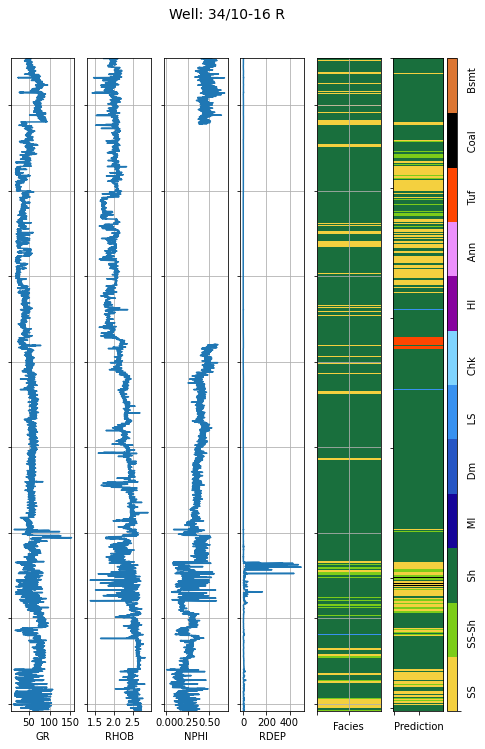

In [18]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

make_facies_log_plot(
    wells_df[wells_df['WELL'] == '34/10-16 R'],
    ['GR', 'RHOB', 'NPHI', 'RDEP'],
    facies_colors)

In [19]:
accuracy_score(wells_df['LITH_LABEL'], wells_df['PRED_LABEL'])
f1_score(wells_df['LITH_LABEL'], wells_df['PRED_LABEL'], average='weighted')

0.7565474186411658

In [20]:
wells_df

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,LITHOLOGY,LITH_LABEL,PRED_LABEL
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,NaN,-0.538873,0.130611,NaN,NaN,NaN,65000,Shale,2,2
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,NaN,-0.539232,0.130611,NaN,NaN,NaN,65000,Shale,2,2
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,NaN,-0.540830,0.130611,NaN,NaN,NaN,65000,Shale,2,2
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,NaN,-0.543943,0.130611,NaN,NaN,NaN,65000,Shale,2,2
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,NaN,-0.542104,0.130611,NaN,NaN,NaN,65000,Shale,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136781,35/9-8,3224.389600,536225.93750,6794880.5,-3199.876465,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.231942,...,NaN,0.063478,NaN,2.618309,33.523922,NaN,30000,Sandstone,0,0
136782,35/9-8,3224.541600,536225.93750,6794880.5,-3200.028320,BAAT GP.,Rannoch Fm.,8.4978,NaN,6.038777,...,NaN,0.056791,NaN,2.620221,32.643795,NaN,30000,Sandstone,0,0
136783,35/9-8,3224.693600,536225.93750,6794880.5,-3200.180176,BAAT GP.,Rannoch Fm.,8.4978,NaN,5.503983,...,NaN,0.002499,NaN,2.629171,31.763380,NaN,30000,Sandstone,0,0
136784,35/9-8,3224.845600,536225.93750,6794880.5,-3200.332031,BAAT GP.,Rannoch Fm.,8.4978,NaN,4.895551,...,NaN,0.003363,NaN,2.521121,30.884350,NaN,30000,Sandstone,0,0


In [21]:
wells_df['WELL'].unique()

array(['15/9-14', '25/10-10', '25/11-24', '25/5-3', '29/3-1',
       '34/10-16 R', '34/3-3 A', '34/6-1 S', '35/6-2 S', '35/9-8'],
      dtype=object)

In [22]:
#initializing the model class

func_= Model(train, test)

In [23]:
#using the make_submission_file method to make predicction and create a submission file

func_.make_submission_file(filename='testing6')

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))
0:	learn: 1.8855421	test: 1.8860309	best: 1.8860309 (0)	total: 14.9s	remaining: 24m 30s


KeyboardInterrupt: 

In [ ]:
a = pd.read_csv('./testing6.csv')
 
a['# lithology'].value_counts()

In [ ]:
prediction

In [ ]:
train

In [ ]:
d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# Without Categorical Features
model2 = lgb.train(params, d_train)